In [1]:
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin
from sklearn.preprocessing import LabelEncoder

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram

import seaborn as sns
sns.set(style='white', context='poster')

In [2]:
DAFX_TO_USE = [
    # 'mda MultiBand',
    # 'clean',
    'mda Delay',
    'mda Overdrive',
    'mda Ambience',
    'mda RingMod',
    # 'mda Leslie',
    'mda Combo',
    # 'mda Thru-Zero Flanger',
    # 'mda Loudness',
    # 'mda Limiter',
    'mda Dynamics',
]

In [3]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 5_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/tuxho3yv/checkpoints/epoch=289-step=60610.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [5]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=131_072,
        effect_audio=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [6]:
latent_embeddings = dict()

In [7]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=37152, out_features=128, bias=True)
  (log_var): Linear(in_features=37152, 

In [8]:
from tqdm import tqdm

embeddings = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_dataset(dafx)

    for x in tqdm(dataset):
        X = audio_to_spectrogram(signal=x,
                                 n_fft=model.hparams.n_fft,
                                 hop_length=model.hparams.hop_length,
                                 window_size=model.hparams.window_size).to(DEVICE)

        _, _, _, z = model(X)

        embeddings.append(z.cpu().detach().numpy())

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 41866.92it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43690.67it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 41909.70it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 44685.08it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 36150.71it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43726.90it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 5000/5000 [00:24<00:00, 207.24it/s]


In [9]:
data = np.array(embeddings).squeeze()

In [10]:
data.shape

(30000, 128)

In [11]:
umap_data = umap.UMAP().fit_transform(data)
umap_labels = np.concatenate([[fx]*NUM_EXAMPLES for fx in DAFX_TO_USE]).squeeze()

In [12]:
plot_labels = LabelEncoder().fit_transform(umap_labels)

In [13]:
num_fx = len(DAFX_TO_USE)

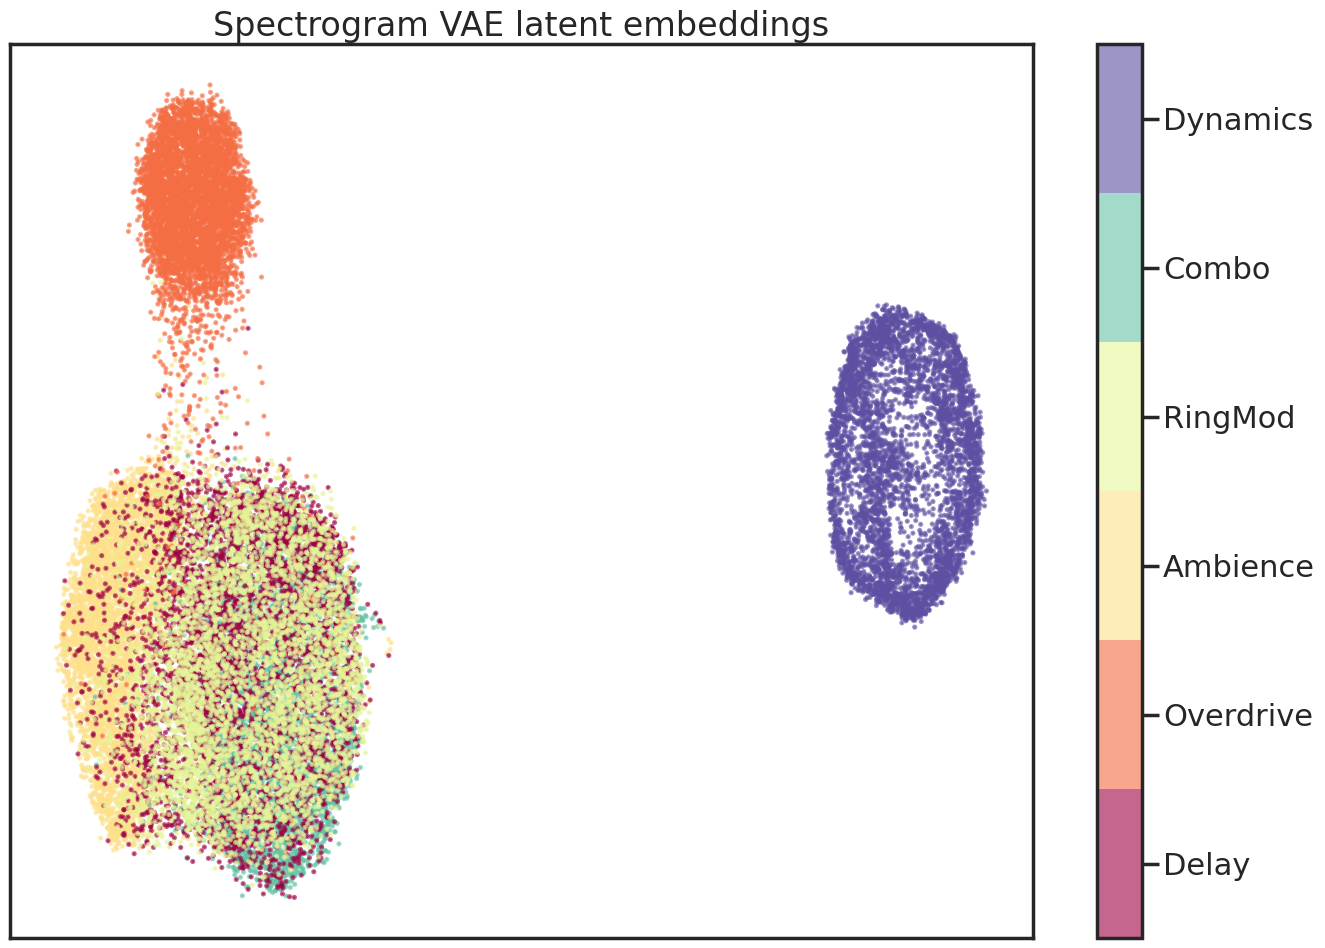

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*umap_data.T, s=3, c=plot_labels, cmap='Spectral', alpha=.6)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(num_fx+1)-0.5)
cbar.set_ticks(np.arange(num_fx))
cbar.set_ticklabels([fx_name.split()[-1] for fx_name in DAFX_TO_USE])
plt.title(f'Spectrogram VAE latent embeddings')
plt.tight_layout()
plt.savefig(f'./figures/latent_analysis/{CHECKPOINT_ID}_{num_fx}dafx.png')